# Imports

In [1]:
import os
import sys
from pathlib import Path

current_dir = os.getcwd()

file = Path(current_dir).resolve()
sys.path.append(str(file.parents[0]))
sys.path.append(str(file.parents[1]))

In [3]:
from data.bids_dataset import BidsDataset
from argparse import Namespace
from utils.brats_tools import plot_slices, get_central_slice_from_tensor, get_central_slice
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

# Creating Bids Dataset and obtaining Soft GTs

In [4]:
conf = Namespace(resize = (152, 192, 144), contrast = 'multimodal', one_hot = False, sigma = 0.125, do2D = False, soft=False, dilate=0)
data_dir = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge'
bids_ds = BidsDataset(conf, data_dir+'/train')

In [5]:
sample = bids_ds[0]
sample_img = sample['img']
sample_gt = sample['seg']
sample_soft_gt = sample['soft_seg']

# Checking Sum across channels for different Sigmas/Parameters

## With Torch

In [19]:
# Step 1: Sum across channels (dim=0)
sum_across_channels = sample_soft_gt.sum(dim=0)

# Step 2: Flatten the summed values to a 1D array for easier processing
flat_sums = sum_across_channels.flatten()

# Step 3: Find unique sum values and their counts
unique_sums, counts = torch.unique(flat_sums, return_counts=True)

In [20]:
#print(sum_across_channels)
print(flat_sums)
print(unique_sums)
print(counts)

metatensor([1., 1., 1.,  ..., 1., 1., 1.])
metatensor([1.])
metatensor([4202496])


## With NumPy

In [21]:
sum_across_channels = np.array(sample_soft_gt.sum(dim=0))
flat_sums = sum_across_channels.flatten()
unique_sums, counts = np.unique(flat_sums, return_counts=True)

In [22]:
#print(sum_across_channels)
#print(flat_sums)
print(unique_sums)
print(counts)

[1.]
[4202496]


# Checking if Softmaxing Improves the Sum accross dims

In [23]:
sample_soft_gt.shape

torch.Size([4, 152, 192, 144])

In [24]:
softmaxed_soft_gt = F.softmax(sample_soft_gt,dim=0)

## With Numpy

In [25]:
sum_across_channels = np.array(softmaxed_soft_gt.sum(dim=0))
flat_sums = sum_across_channels.flatten()
unique_sums, counts = np.unique(flat_sums, return_counts=True)

In [26]:
#print(sum_across_channels)
#print(flat_sums)
print(unique_sums)
print(counts)

[0.99999994 1.         1.0000001 ]
[  15111   81526 4105859]


## Plotting the GTs and looking at them

### Soft GTs

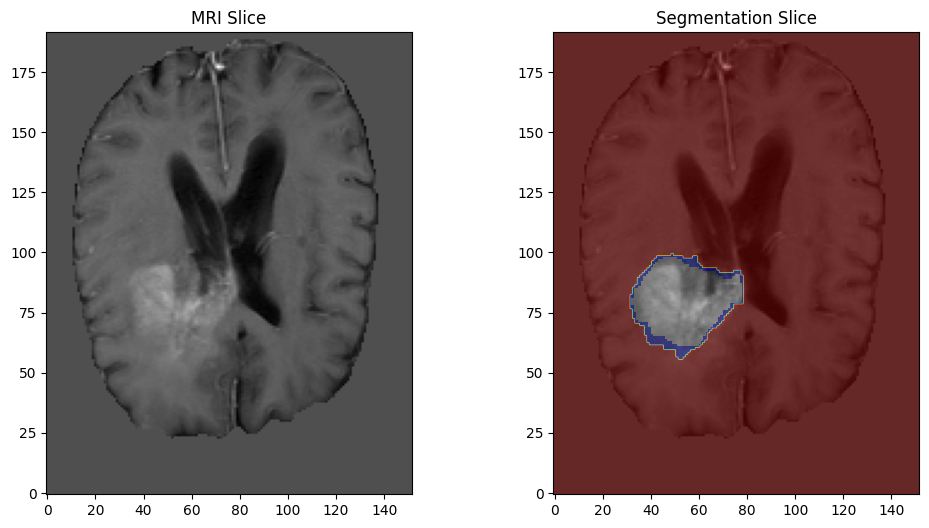

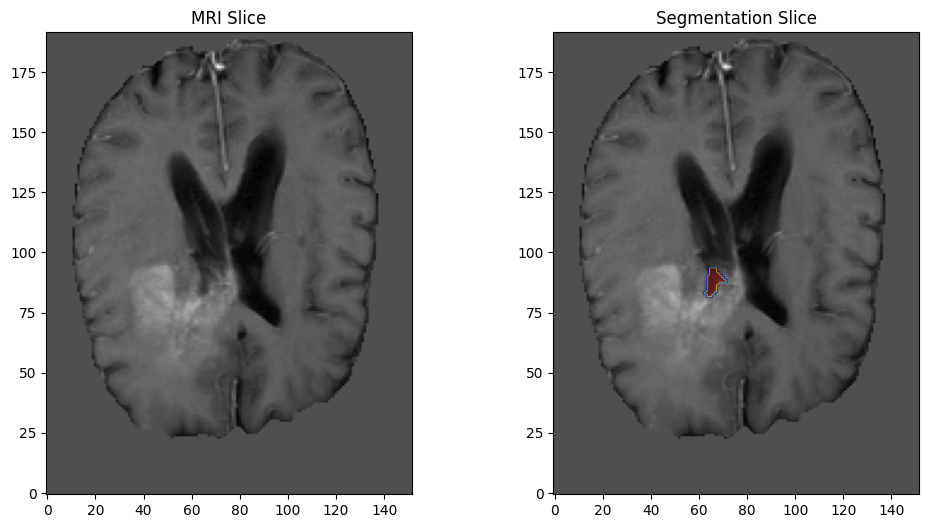

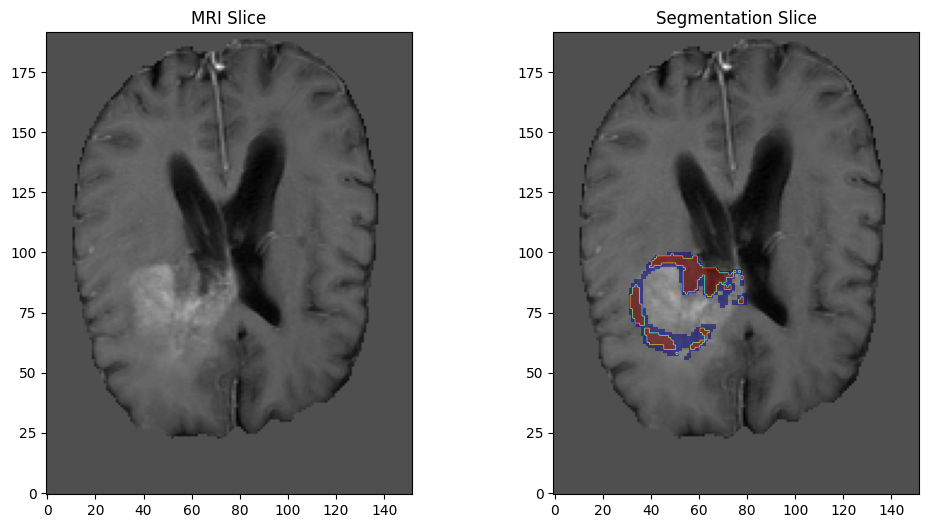

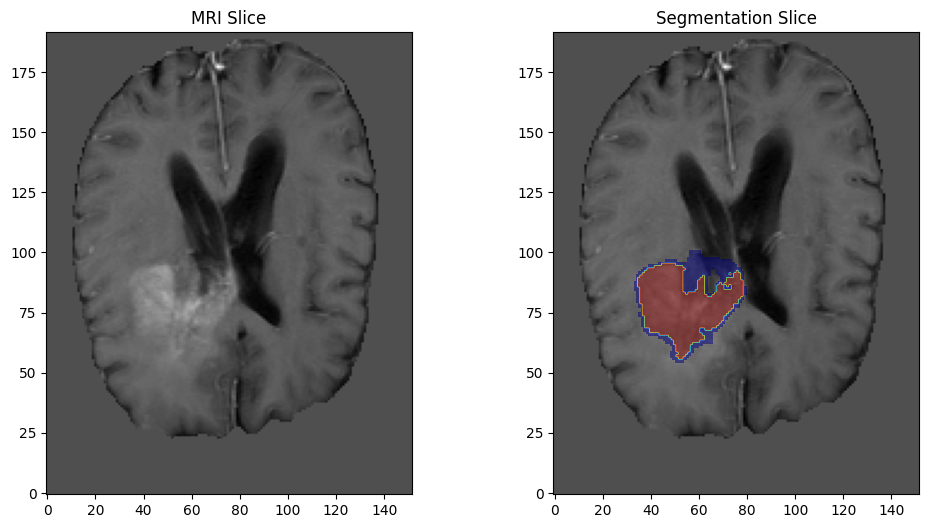

In [27]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[0], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[1], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[2], axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[3], axis))

### Sum across channels plotted over Image

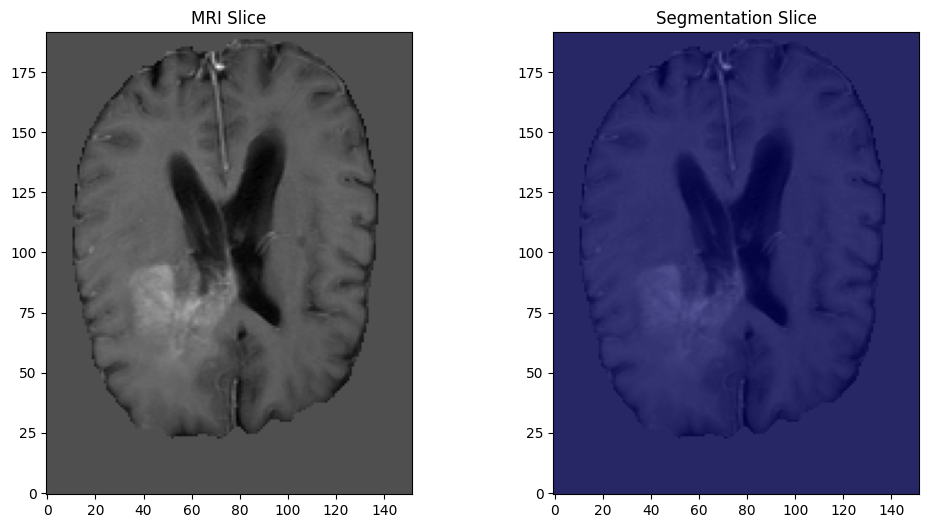

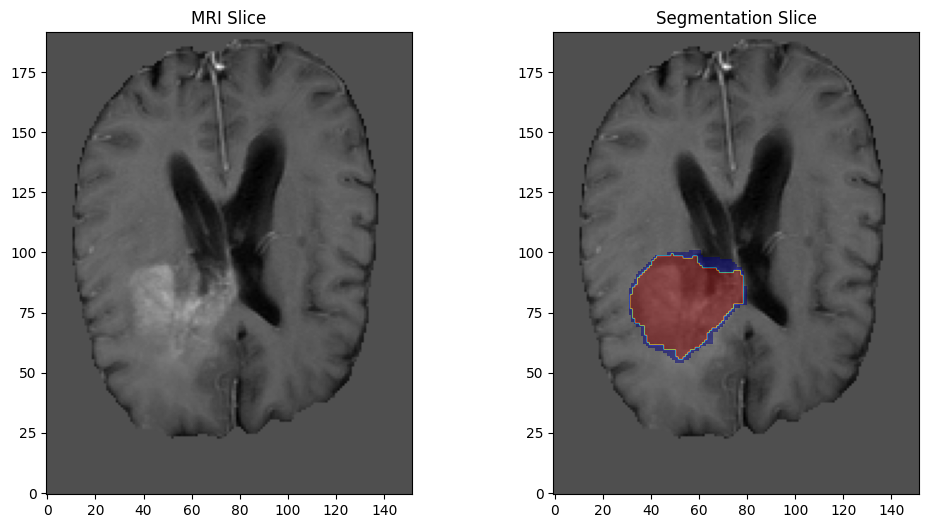

In [33]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt.sum(dim=0), axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_soft_gt[1:,:].sum(dim=0), axis))

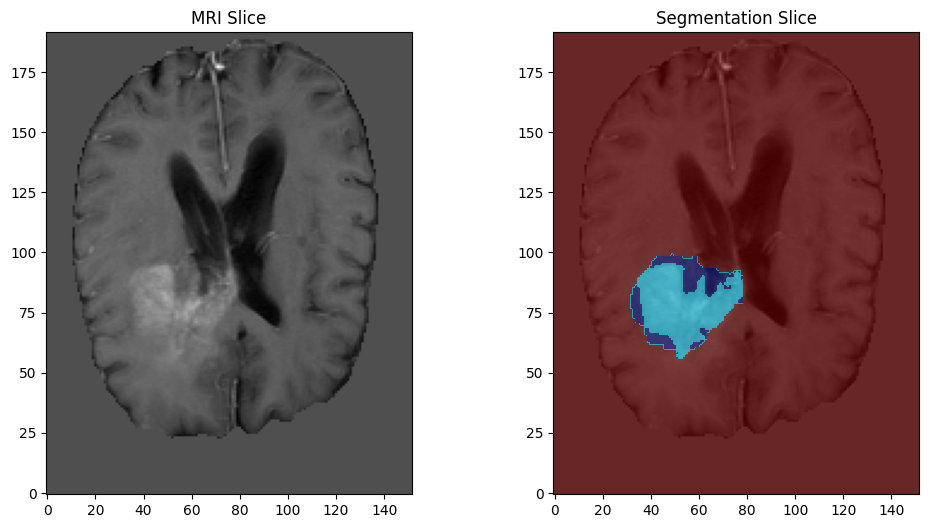

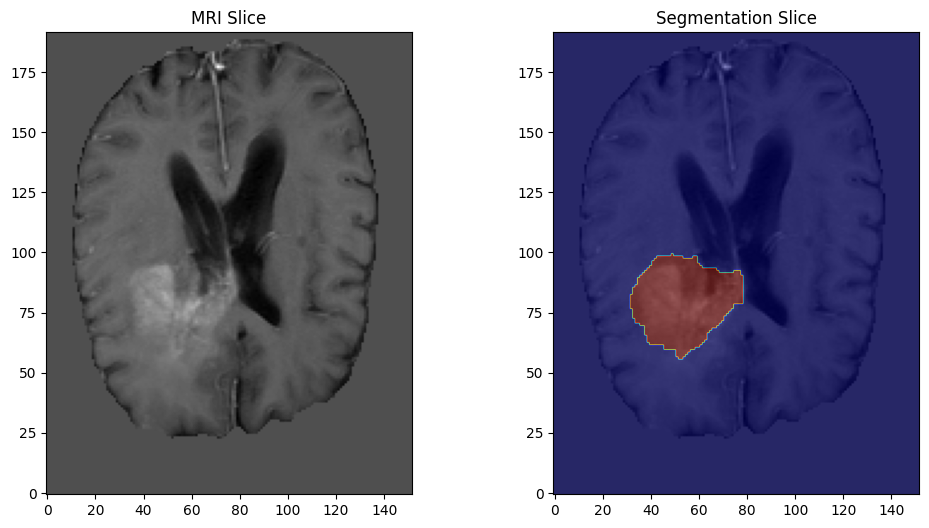

In [31]:
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(softmaxed_soft_gt.sum(dim=0), axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(softmaxed_soft_gt[1:,:].sum(dim=0), axis))

### Hard GTs for comparison

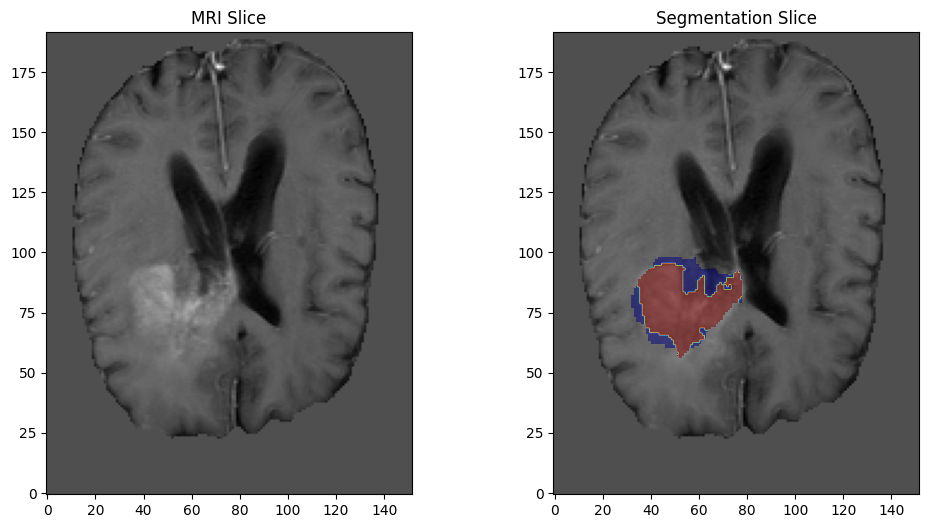

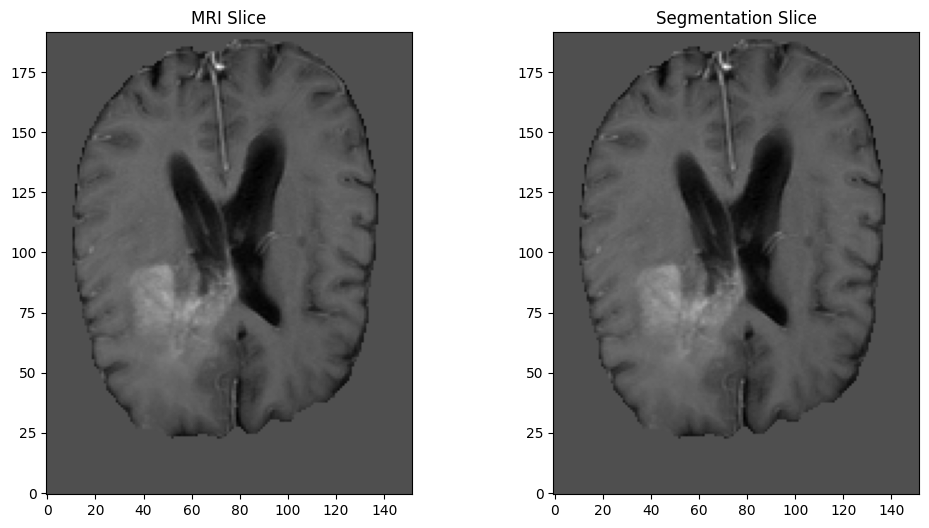

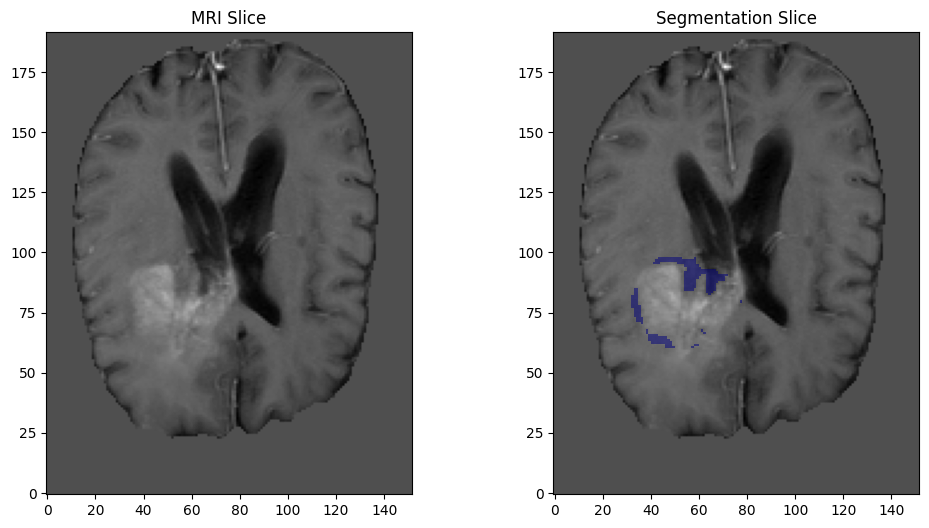

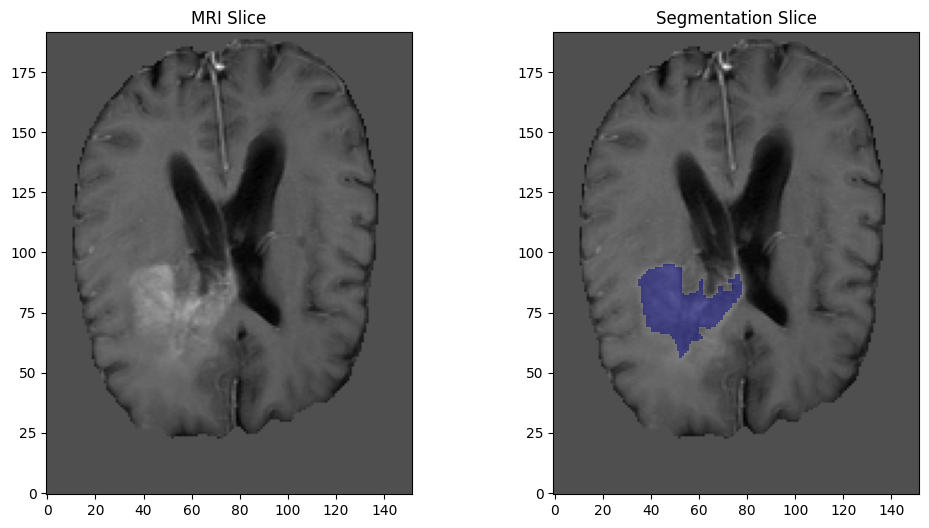

In [16]:
axis = 2
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice(sample_gt, axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice((sample_gt == 1).long(), axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice((sample_gt == 2).long(), axis))
plot_slices(get_central_slice(sample_img[0], axis), get_central_slice((sample_gt == 3).long(), axis))

# Looping all of this over the DS with same sigma for X Samples

## Sigma 0.125 (Min Value)

In [9]:
sigma = 0.125
conf = Namespace(resize = (152, 192, 144), contrast = 'multimodal', one_hot = False, sigma = sigma, do2D = False, soft=False, dilate=0)
bids_ds = BidsDataset(conf, data_dir+'/train')

In [7]:
num_samples = 10
start_idx = 50

In [8]:
print(f" Values for softening with sigma {sigma}")

for idx in range(10):
    sample_soft_gt = bids_ds[start_idx+idx]["soft_seg"]
    sum_across_channels = np.array(sample_soft_gt.sum(dim=0))
    flat_sums = sum_across_channels.flatten()
    unique_sums, counts = np.unique(flat_sums, return_counts=True)
    print(f"------------------------------------------------")
    print(f"For Sample {idx}:")
    print(f"unique_sums {unique_sums}")
    print(f"num of unique vals: {unique_sums.shape[0]}")
    print(f"counts {counts}")
    print("After Softmax")
    softmaxed_soft_gt = F.softmax(sample_soft_gt,dim=0)
    sum_across_channels = np.array(softmaxed_soft_gt.sum(dim=0))
    flat_sums = sum_across_channels.flatten()
    unique_sums, counts = np.unique(flat_sums, return_counts=True)
    print(f"unique_sums {unique_sums}")
    print(f"num of unique vals: {unique_sums.shape[0]}")
    print(f"counts {counts}")
    

 Values for softening with sigma 0.125
------------------------------------------------
For Sample 0:
unique_sums [1.]
num of unique vals: 1
counts [4202496]
After Softmax
unique_sums [0.99999994 1.         1.0000001 ]
num of unique vals: 3
counts [  13553   32292 4156651]
------------------------------------------------
For Sample 1:
unique_sums [1.]
num of unique vals: 1
counts [4202496]
After Softmax
unique_sums [0.99999994 1.         1.0000001 ]
num of unique vals: 3
counts [  12329     157 4190010]
------------------------------------------------
For Sample 2:
unique_sums [1.]
num of unique vals: 1
counts [4202496]
After Softmax
unique_sums [0.99999994 1.         1.0000001 ]
num of unique vals: 3
counts [  79234   73389 4049873]
------------------------------------------------
For Sample 3:
unique_sums [1.]
num of unique vals: 1
counts [4202496]
After Softmax
unique_sums [0.99999994 1.         1.0000001 ]
num of unique vals: 3
counts [   6275    1238 4194983]
---------------------

## Sigma 0.25

In [10]:
sigma = 0.25
conf = Namespace(resize = (152, 192, 144), contrast = 'multimodal', one_hot = False, sigma = sigma, do2D = False, soft=False, dilate=0)
bids_ds = BidsDataset(conf, data_dir+'/train')

In [11]:
num_samples = 10
start_idx = 50

In [12]:
print(f" Values for softening with sigma {sigma}")

for idx in range(10):
    sample_soft_gt = bids_ds[start_idx+idx]["soft_seg"]
    sum_across_channels = np.array(sample_soft_gt.sum(dim=0))
    flat_sums = sum_across_channels.flatten()
    unique_sums, counts = np.unique(flat_sums, return_counts=True)
    print(f"------------------------------------------------")
    print(f"For Sample {idx}:")
    print(f"unique_sums {unique_sums}")
    print(f"num of unique vals: {unique_sums.shape[0]}")
    print(f"counts {counts}")
    print("After Softmax")
    softmaxed_soft_gt = F.softmax(sample_soft_gt,dim=0)
    sum_across_channels = np.array(softmaxed_soft_gt.sum(dim=0))
    flat_sums = sum_across_channels.flatten()
    unique_sums, counts = np.unique(flat_sums, return_counts=True)
    print(f"unique_sums {unique_sums}")
    print(f"num of unique vals: {unique_sums.shape[0]}")
    print(f"counts {counts}")
    

 Values for softening with sigma 0.25
------------------------------------------------
For Sample 0:
unique_sums [0.99999994 1.        ]
num of unique vals: 2
counts [    443 4202053]
After Softmax
unique_sums [0.9999999  0.99999994 1.         1.0000001 ]
num of unique vals: 4
counts [   4897   12361   40464 4144774]
------------------------------------------------
For Sample 1:
unique_sums [1.]
num of unique vals: 1
counts [4202496]
After Softmax
unique_sums [0.9999999  0.99999994 1.         1.0000001 ]
num of unique vals: 4
counts [    461    9839    4270 4187926]
------------------------------------------------
For Sample 2:
unique_sums [0.99999994 1.        ]
num of unique vals: 2
counts [    304 4202192]
After Softmax
unique_sums [0.9999999  0.99999994 1.         1.0000001 ]
num of unique vals: 4
counts [   4650   66993   93036 4037817]
------------------------------------------------
For Sample 3:
unique_sums [0.99999994 1.        ]
num of unique vals: 2
counts [     75 4202421]


## Sigma 0.5

In [13]:
sigma = 0.5
conf = Namespace(resize = (152, 192, 144), contrast = 'multimodal', one_hot = False, sigma = sigma, do2D = False, soft=False, dilate=0)
bids_ds = BidsDataset(conf, data_dir+'/train')

In [14]:
num_samples = 10
start_idx = 80

In [15]:
print(f" Values for softening with sigma {sigma}")

for idx in range(10):
    sample_soft_gt = bids_ds[start_idx+idx]["soft_seg"]
    sum_across_channels = np.array(sample_soft_gt.sum(dim=0))
    flat_sums = sum_across_channels.flatten()
    unique_sums, counts = np.unique(flat_sums, return_counts=True)
    print(f"------------------------------------------------")
    print(f"For Sample {idx}:")
    print(f"unique_sums {unique_sums}")
    print(f"num of unique vals: {unique_sums.shape[0]}")
    print(f"counts {counts}")
    print("After Softmax")
    softmaxed_soft_gt = F.softmax(sample_soft_gt,dim=0)
    sum_across_channels = np.array(softmaxed_soft_gt.sum(dim=0))
    flat_sums = sum_across_channels.flatten()
    unique_sums, counts = np.unique(flat_sums, return_counts=True)
    print(f"unique_sums {unique_sums}")
    print(f"num of unique vals: {unique_sums.shape[0]}")
    print(f"counts {counts}")

 Values for softening with sigma 0.5
------------------------------------------------
For Sample 0:
unique_sums [0.9999999  0.99999994 1.         1.0000001 ]
num of unique vals: 4
counts [      1    2348 4200077      70]
After Softmax
unique_sums [0.9999998  0.9999999  0.99999994 1.         1.0000001  1.0000002 ]
num of unique vals: 6
counts [     15    5256   34751   82372 4080097       5]
------------------------------------------------
For Sample 1:
unique_sums [0.99999994 1.         1.0000001 ]
num of unique vals: 3
counts [   1817 4200666      13]
After Softmax
unique_sums [0.9999998  0.9999999  0.99999994 1.         1.0000001  1.0000002 ]
num of unique vals: 6
counts [     23    9978  166755  168040 3857699       1]
------------------------------------------------
For Sample 2:
unique_sums [0.99999994 1.         1.0000001 ]
num of unique vals: 3
counts [   1409 4201065      22]
After Softmax
unique_sums [0.9999998  0.9999999  0.99999994 1.         1.0000001 ]
num of unique vals: 

## Sigma 1

In [42]:
sigma = 1
conf = Namespace(resize = (152, 192, 144), contrast = 'multimodal', one_hot = False, sigma = sigma, do2D = False, soft=False, dilate=0)
bids_ds = BidsDataset(conf, data_dir+'/train')

In [43]:
num_samples = 10
start_idx = 0

In [45]:
print(f" Values for softening with sigma {sigma}")

for idx in range(10):
    sample_soft_gt = bids_ds[start_idx+idx]["soft_seg"]
    sum_across_channels = np.array(sample_soft_gt.sum(dim=0))
    flat_sums = sum_across_channels.flatten()
    unique_sums, counts = np.unique(flat_sums, return_counts=True)
    print(f"------------------------------------------------")
    print(f"For Sample {idx}:")
    print(f"unique_sums {unique_sums}")
    print(f"num of unique vals: {unique_sums.shape[0]}")
    print(f"counts {counts}")
    print("After Softmax")
    softmaxed_soft_gt = F.softmax(sample_soft_gt,dim=0)
    sum_across_channels = np.array(softmaxed_soft_gt.sum(dim=0))
    flat_sums = sum_across_channels.flatten()
    unique_sums, counts = np.unique(flat_sums, return_counts=True)
    print(f"unique_sums {unique_sums}")
    print(f"num of unique vals: {unique_sums.shape[0]}")
    print(f"counts {counts}")

 Values for softening with sigma 1
------------------------------------------------
For Sample 0:
unique_sums [0.9999999  0.99999994 1.         1.0000001 ]
num of unique vals: 4
counts [      6    9673 4192549     268]
After Softmax
unique_sums [0.9999998  0.9999999  0.99999994 1.         1.0000001  1.0000002 ]
num of unique vals: 6
counts [     98   11984   35544  161740 3993107      23]
------------------------------------------------
For Sample 1:
unique_sums [0.99999994 1.         1.0000001 ]
num of unique vals: 3
counts [   1054 4201386      56]
After Softmax
unique_sums [0.9999998  0.9999999  0.99999994 1.         1.0000001 ]
num of unique vals: 5
counts [      1    1701   10021   32964 4157809]
------------------------------------------------
For Sample 2:
unique_sums [0.9999999  0.99999994 1.         1.0000001 ]
num of unique vals: 4
counts [     11    7650 4194337     498]
After Softmax
unique_sums [0.9999998  0.9999999  0.99999994 1.         1.0000001  1.0000002 ]
num of uniq